<p align="center">
  <img src="images/vertical-maroon-on-white-full-name.PNG" width="220"/>
</p>

<h1 align="center">Bank Marketing Classification Project</h1>

<p align="center">
<h2>Gradient Boosting vs. Logistic Regression</h2> 
<br>
<h3>Mountainland Technical College</h3>  
<br>
Jake Jarrard - Instructor - Data Technologies Course Feb 2026  
</p>


In a quick search for a dataset that could be used to demonstrate my knowledge of Machine Learning (ML) models that we learned in class this year, I determined that the Bank Marketing Dataset (below) gave me the right amount of depth, size, and sophistication to evaluate at least two different ML algorithms. I decided to try the classic logistic regression (clf) and then compare it to gradient boosting (gbc). Both performed generally well, with the gbc model having a much better recall than the clf model. Given that the outcome, or target variable, was highly skewed, it was evident that there would be some issues making a fair model that generally performed well against all metrics. 

### Introduction - Bank Marketing Dataset  

**Source:**  
UCI Machine Learning Repository.  
[Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing)

This dataset contains information related to direct marketing campaigns conducted by a Portuguese banking institution.  
The campaigns were based on telephone calls, and in many cases multiple contacts with the same client were required to determine whether the client would subscribe to a bank term deposit (`"yes"`) or not (`"no"`). A well-written data dictionary can be reviewed at the source URL above.


Citation: Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

### Load our Python Packages for ML

In [1]:
# Core
import pandas as pd
import matplotlib.pyplot as plt

# sklearn: preprocessing + pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# sklearn: modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# sklearn: model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict

# sklearn: metrics + displays
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score,
    classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)


### Data Import from Source

In [2]:
%%capture
!pip install ucimlrepo


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
# print(bank_marketing.metadata) 
  
# variable information 
# print(bank_marketing.variables) 


In [4]:
# Combine features and target into one dataframe
df = pd.concat([X, y], axis=1)

print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# print("\nData types:")
# print(df.dtypes)

#print("\nMissing values per column:")
#print(df.isnull().sum())


Shape: (45211, 17)

First 5 rows:


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [5]:
df.info()
display(df.head())

# target balance
display(df['y'].value_counts())
display(df['y'].value_counts(normalize=True))

# check missing / unknowns
# print("Nulls:")
# display(df.isnull().sum())

print("Unknowns:")
unknowns = df.apply(lambda col: (col == "unknown").sum() if col.dtype == "object" else 0)
display(unknowns[unknowns > 0].sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


y
no     39922
yes     5289
Name: count, dtype: int64

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

Unknowns:


Series([], dtype: int64)

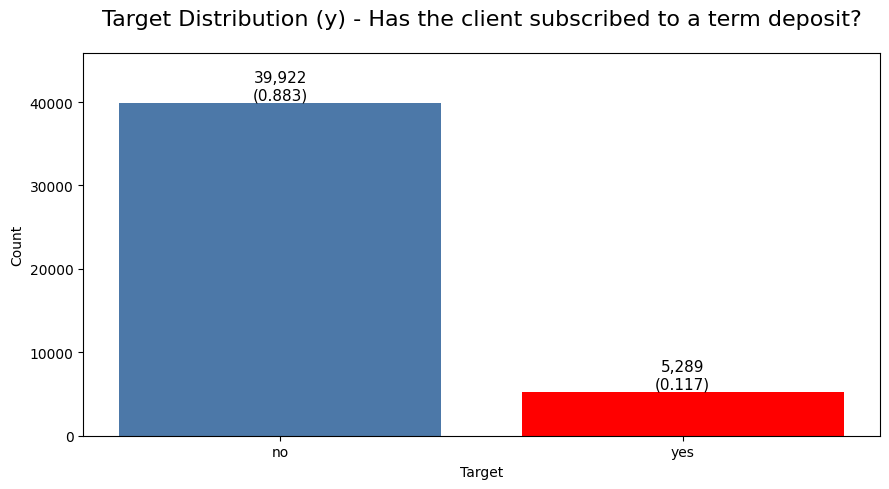

In [6]:
# Counts + proportions
target_counts = df["y"].value_counts()
target_props  = df["y"].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.bar(
    target_counts.index.astype(str),
    target_counts.values,
    color=["#4C78A8", "red"]
)

# Add extra vertical space above bars
ax.set_ylim(0, target_counts.max() * 1.15)

# Title with padding
ax.set_title("Target Distribution (y) - Has the client subscribed to a term deposit?", fontsize=16, pad=20)

ax.set_xlabel("Target")
ax.set_ylabel("Count")

# Add labels
for bar, label in zip(bars, target_counts.index):
    count = target_counts[label]
    prop = target_props[label]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{count:,}\n({prop:.3f})",
        ha="center",
        va="bottom",
        fontsize=11
    )

# Better centering + spacing
plt.tight_layout()
plt.show()


Our dataset is skewed - .883 no and .117 yes 

Comment: So we have null values in job, education, contact, and poutcome - I want to look at the values in these columns

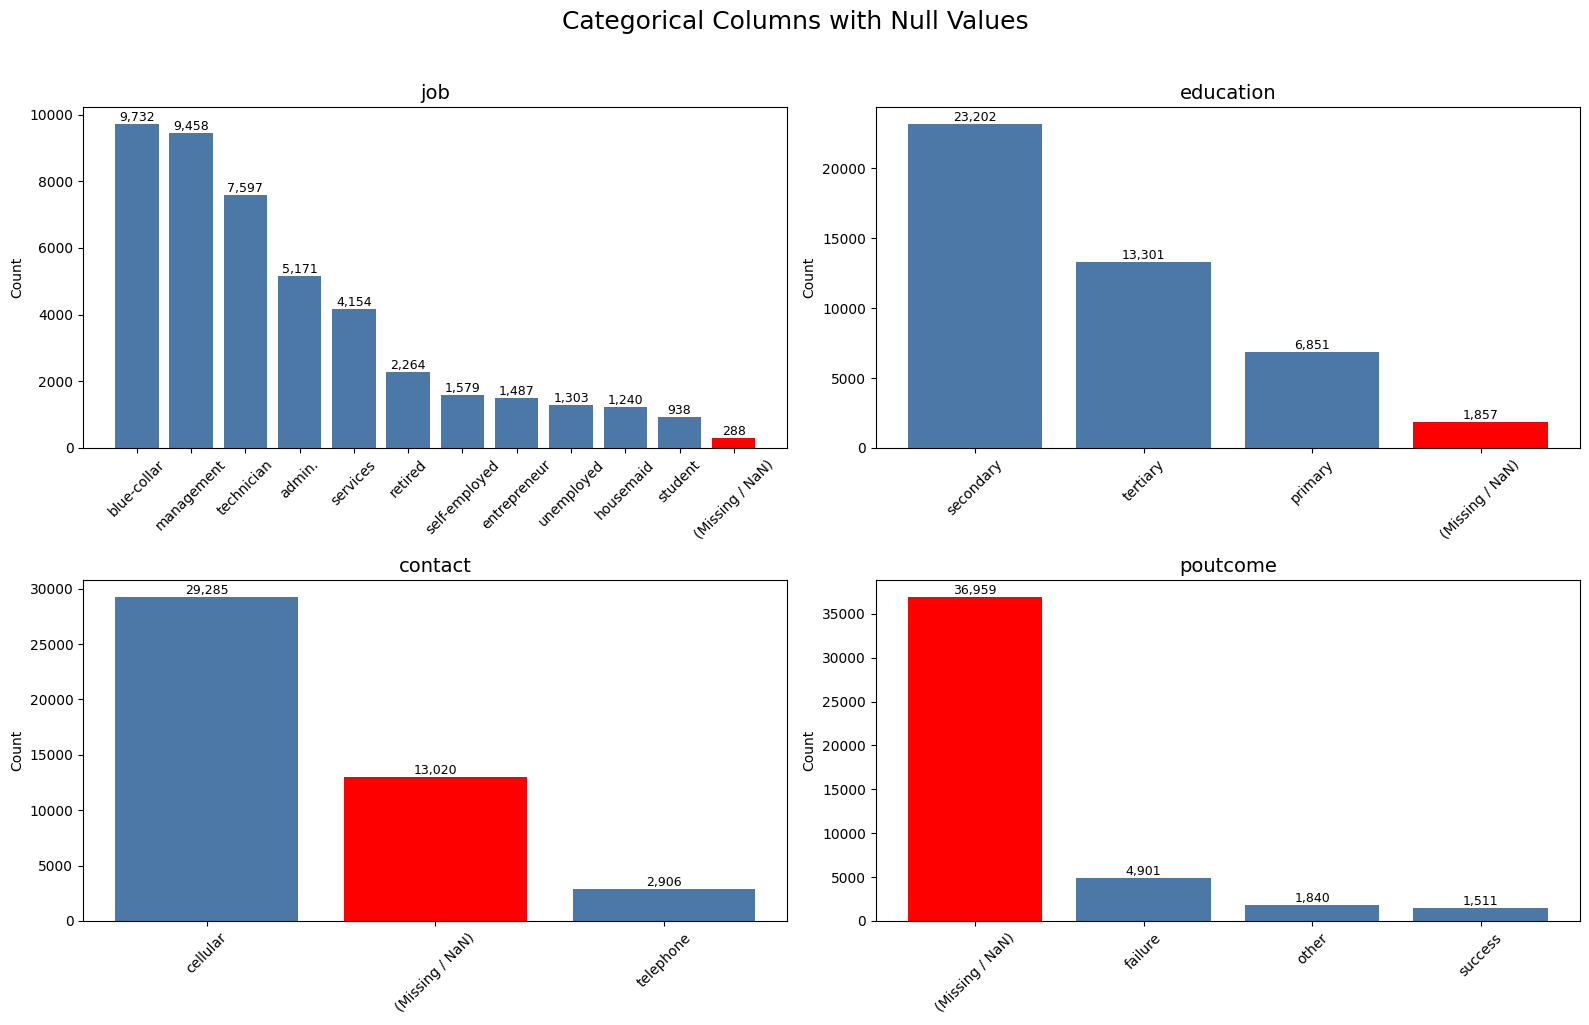

In [7]:
cols = ["job", "education", "contact", "poutcome"]

fig, axes = plt.subplots(2, 2, figsize=(16, 10)) #Makes my output have 2 x 2 charts, and makes it a large output...
axes = axes.flatten()

for ax, col in zip(axes, cols):
    # Make NaN explicit so it shows up in counts
    s = df[col].astype("object").where(~df[col].isna(), "(Missing / NaN)")

    vc = s.value_counts(dropna=False)

    # Keep chart readable: top 12 categories + Other
    max_cats = 12
    if len(vc) > max_cats:
        top = vc.iloc[:max_cats]
        other = vc.iloc[max_cats:].sum()
        vc = pd.concat([top, pd.Series({"Other": other})])

    # Color "none" red, everything else blue
    colors = ["red" if str(cat) == "(Missing / NaN)" else "#4C78A8" for cat in vc.index]

    ax.bar(vc.index.astype(str), vc.values, color=colors)
    ax.set_title(f"{col}", fontsize=14)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

    # Add labels on bars
    for i, v in enumerate(vc.values):
        ax.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)

fig.suptitle("Categorical Columns with Null Values", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()



In [8]:
df["day_of_week"] = df["day_of_week"].astype(str) #need a quick fix here 


So, just to keep it simple, for all the null values in the dataframe, and there are only 4 input variables here, I am going to call the nulls = "none" as it works in each case.

In [9]:
df[cols] = df[cols].fillna("none")


Okay Beautiful, I now have all values appropriately imputed.

## BEGIN EDA

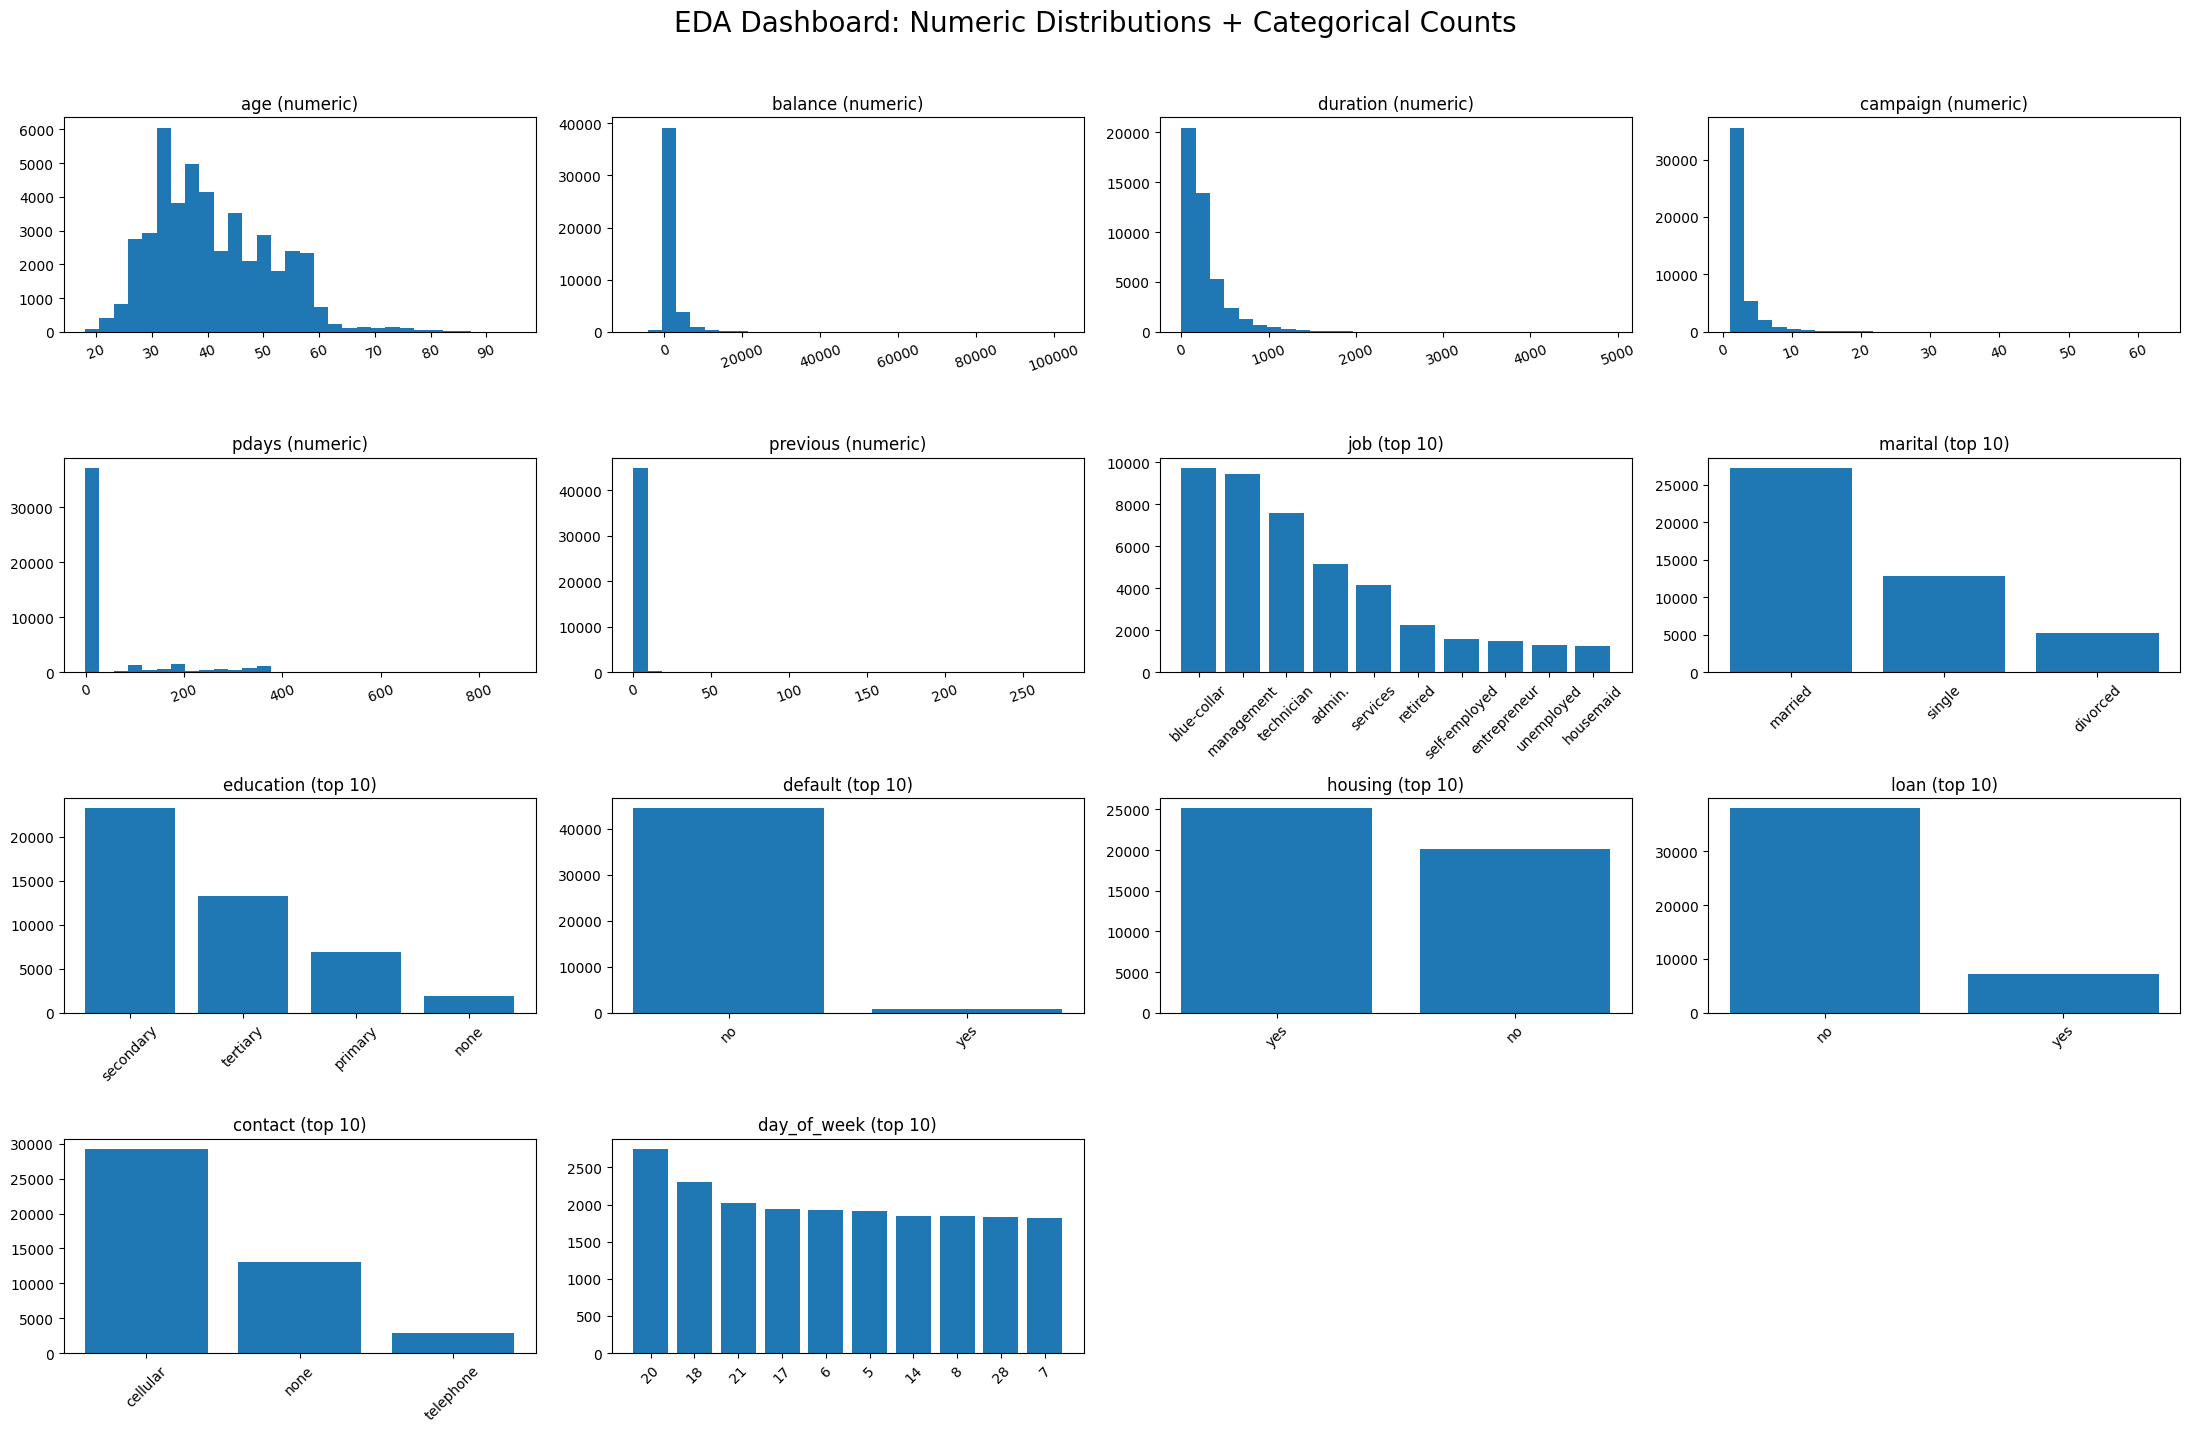

In [10]:
# Split columns
target_col = "y"
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop(target_col, errors="ignore")
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.drop(target_col, errors="ignore")

# Pick a manageable number of columns for a single dashboard
numeric_cols = list(numeric_cols)
categorical_cols = list(categorical_cols)

# Limit how many categorical columns we plot (so it's readable)
max_cat_cols = 8
cat_cols_to_plot = categorical_cols[:max_cat_cols]

# Create a big figure
n_rows = 4
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 14))
axes = axes.flatten()

plot_idx = 0

# --- Numeric histograms ---
for col in numeric_cols:
    if plot_idx >= len(axes):
        break

    ax = axes[plot_idx]
    ax.hist(df[col].dropna(), bins=30)
    ax.set_title(f"{col} (numeric)", fontsize=12)
    ax.tick_params(axis="x", rotation=20)
    plot_idx += 1

# --- Categorical bar charts ---
for col in cat_cols_to_plot:
    if plot_idx >= len(axes):
        break

    ax = axes[plot_idx]
    vc = df[col].fillna("none").value_counts().head(10)

    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(f"{col} (top 10)", fontsize=12)
    ax.tick_params(axis="x", rotation=45)
    plot_idx += 1

# Turn off unused axes
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

fig.suptitle("EDA Dashboard: Numeric Distributions + Categorical Counts", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


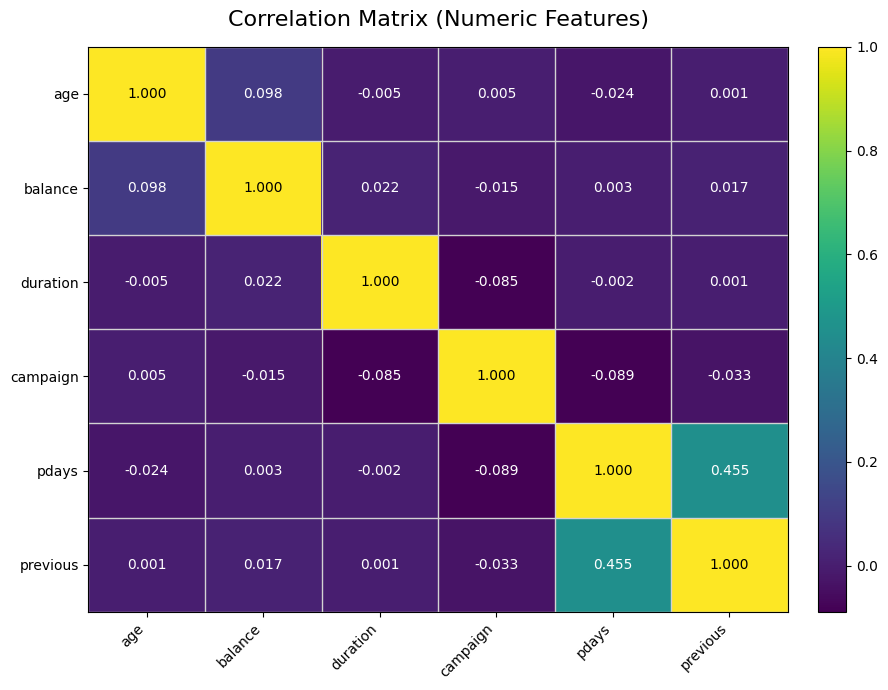

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Select numeric columns + correlation
numeric_df = df.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(9, 7))

# Heatmap
im = ax.imshow(corr, aspect="auto")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Axis labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

# Light gray gridlines between cells
ax.set_xticks(np.arange(-0.5, len(corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(corr.columns), 1), minor=True)
ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate values
threshold = 0.5

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        val = corr.iloc[i, j]
        text_color = "white" if abs(val) < threshold else "black"
        ax.text(j, i, f"{val:.3f}", ha="center", va="center", color=text_color, fontsize=10)

ax.set_title("Correlation Matrix (Numeric Features)", fontsize=16, pad=15)
plt.tight_layout()
plt.show()



### Preprocessing

In [12]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns

print("Numeric:", list(numeric_cols))
print("Categorical:", list(categorical_cols))


Numeric: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


### Pipeline Prep

In [13]:
# Preprocess numeric + categorical
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


## Run Logistic Regression + Pipeline

In [14]:
# X / y
X = df.drop("y", axis=1)
y = df["y"].map({"no": 0, "yes": 1})

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# model
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])

clf.fit(X_train, y_train)
print(clf)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncode

### Metrics and Output of Logistic Regression

ROC-AUC:  0.906
PR-AUC:   0.545

              precision    recall  f1-score   support

           0      0.919     0.975     0.946      7985
           1      0.644     0.348     0.452      1058

    accuracy                          0.901      9043
   macro avg      0.782     0.661     0.699      9043
weighted avg      0.886     0.901     0.888      9043



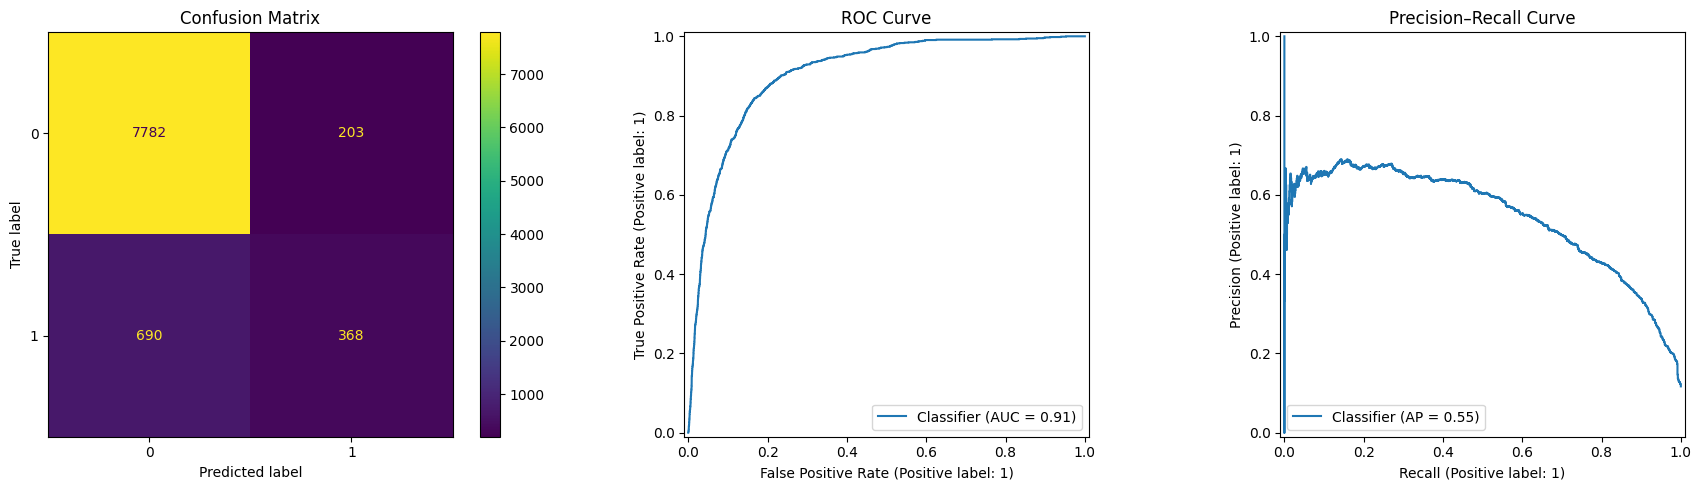

In [15]:
# predicted probabilities
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

# scores
roc = roc_auc_score(y_test, y_proba)
prauc = average_precision_score(y_test, y_proba)

print(f"ROC-AUC:  {roc:.3f}")
print(f"PR-AUC:   {prauc:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

# plots (one output figure)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], values_format="d")
axes[0].set_title("Confusion Matrix")

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curve")

# Precision-Recall curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
axes[2].set_title("Precision–Recall Curve")

plt.tight_layout()
plt.show()


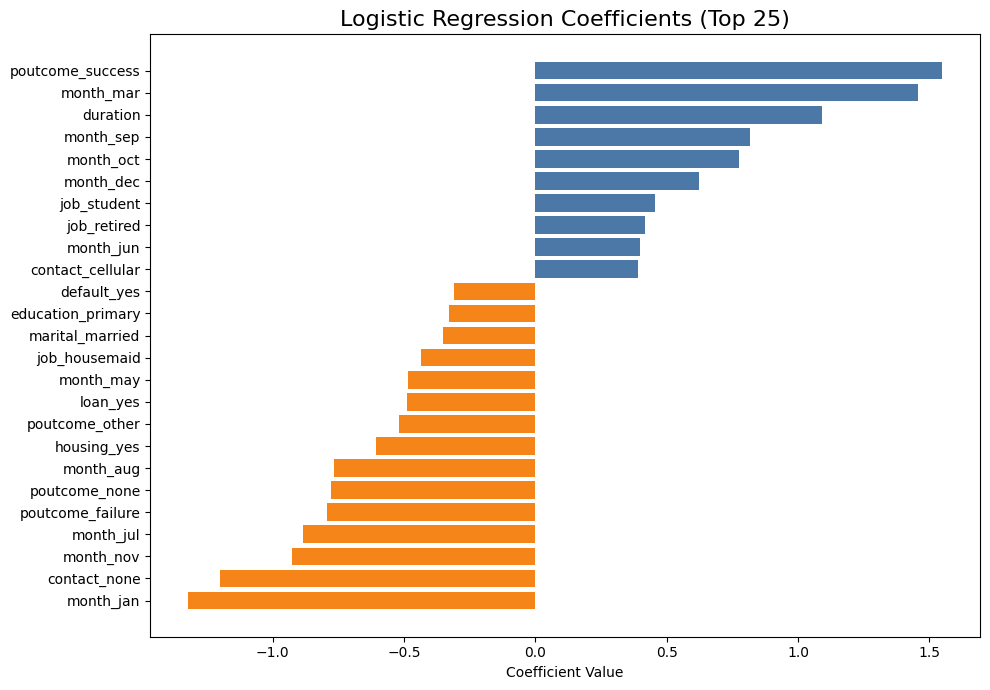

,feature,coefficient,abs_coef
50,poutcome_success,1.549282,1.549282
42,month_mar,1.457573,1.457573
39,month_jan,-1.321511,1.321511
33,contact_none,-1.201578,1.201578
3,duration,1.091874,1.091874
44,month_nov,-0.927599,0.927599
40,month_jul,-0.883044,0.883044
46,month_sep,0.816278,0.816278
47,poutcome_failure,-0.792804,0.792804
48,poutcome_none,-0.778145,0.778145


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1️ Extract fitted preprocessor + model
pre = clf.named_steps["preprocess"]
model = clf.named_steps["model"]

# 2️ Get feature names after preprocessing
num_features = pre.transformers_[0][2]

ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_features = pre.transformers_[1][2]
cat_feature_names = ohe.get_feature_names_out(cat_features)

feature_names = list(num_features) + list(cat_feature_names)

# 3️ Extract coefficients
coefs = model.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

# 4 Plot Top 25
top_n = 25
top = coef_df.head(top_n).sort_values("coefficient")

fig, ax = plt.subplots(figsize=(10, 7))

colors = ["#4C78A8" if c > 0 else "#F58518" for c in top["coefficient"]]

ax.barh(top["feature"], top["coefficient"], color=colors)
ax.set_title(f"Logistic Regression Coefficients (Top {top_n})", fontsize=16)
ax.set_xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

coef_df.head(25)


## Run Gradient Boosting + Pipeline 

In [17]:
gbc = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8
    ))
])

gbc.fit(X_train, y_train)
print(gbc)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncode

### Metrics and Output of GBC

ROC-AUC:  0.928
PR-AUC:   0.613

              precision    recall  f1-score   support

           0      0.928     0.970     0.949      7985
           1      0.656     0.432     0.521      1058

    accuracy                          0.907      9043
   macro avg      0.792     0.701     0.735      9043
weighted avg      0.896     0.907     0.898      9043



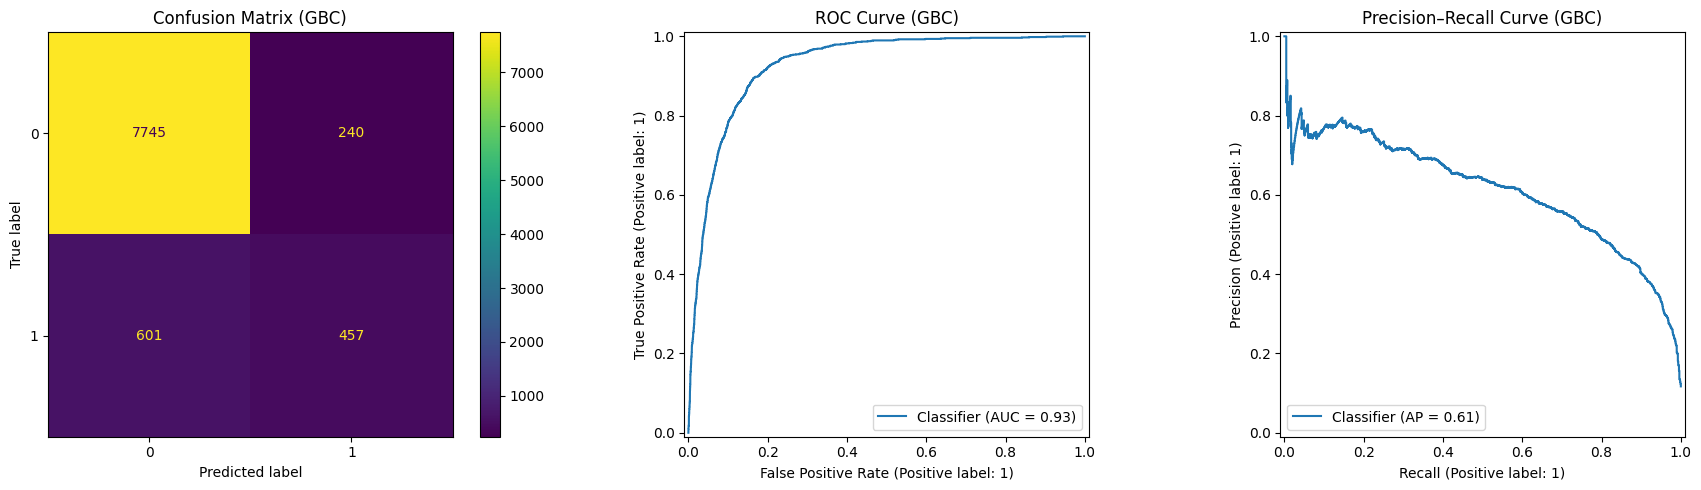

In [18]:
y_proba = gbc.predict_proba(X_test)[:, 1]
y_pred  = gbc.predict(X_test)

print(f"ROC-AUC:  {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_proba):.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], values_format="d")
axes[0].set_title("Confusion Matrix (GBC)")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curve (GBC)")

PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
axes[2].set_title("Precision–Recall Curve (GBC)")

plt.tight_layout()
plt.show()


### Quality Control with some K-Fold Cross Validation

In [19]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Out-of-fold probabilities
y_proba_cv = cross_val_predict(
    gbc,
    X,
    y,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# Out-of-fold class predictions
y_pred_cv = (y_proba_cv >= 0.5).astype(int)

roc_cv = roc_auc_score(y, y_proba_cv)
pr_cv  = average_precision_score(y, y_proba_cv)
acc_cv = accuracy_score(y, y_pred_cv)

print("10-Fold Cross-Validation Results (Gradient Boosting)")
print(f"ROC-AUC:  {roc_cv:.3f}")
print(f"PR-AUC:   {pr_cv:.3f}")
print(f"Accuracy: {acc_cv:.3f}")


10-Fold Cross-Validation Results (Gradient Boosting)
ROC-AUC:  0.930
PR-AUC:   0.615
Accuracy: 0.907


## Compare Logistic Regression vs. GBC

In [20]:
def eval_model(name, model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    return {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "PR_AUC": average_precision_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (class 1)": precision_score(y_test, y_pred, pos_label=1),
        "Recall (class 1)": recall_score(y_test, y_pred, pos_label=1),
        "F1 (class 1)": f1_score(y_test, y_pred, pos_label=1),
    }

results = pd.DataFrame([
    eval_model("Logistic Regression", clf, X_test, y_test),
    eval_model("GradientBoostingClassifier", gbc, X_test, y_test),
])

# Pretty formatting
results_fmt = results.copy()
for c in results.columns:
    if c != "Model":
        results_fmt[c] = results[c].map(lambda x: f"{x:.3f}")

results_fmt



,Model,ROC_AUC,PR_AUC,Accuracy,Precision (class 1),Recall (class 1),F1 (class 1)
0,Logistic Regression,0.906,0.545,0.901,0.644,0.348,0.452
1,GradientBoostingClassifier,0.928,0.613,0.907,0.656,0.432,0.521


## GBC Feature Importance

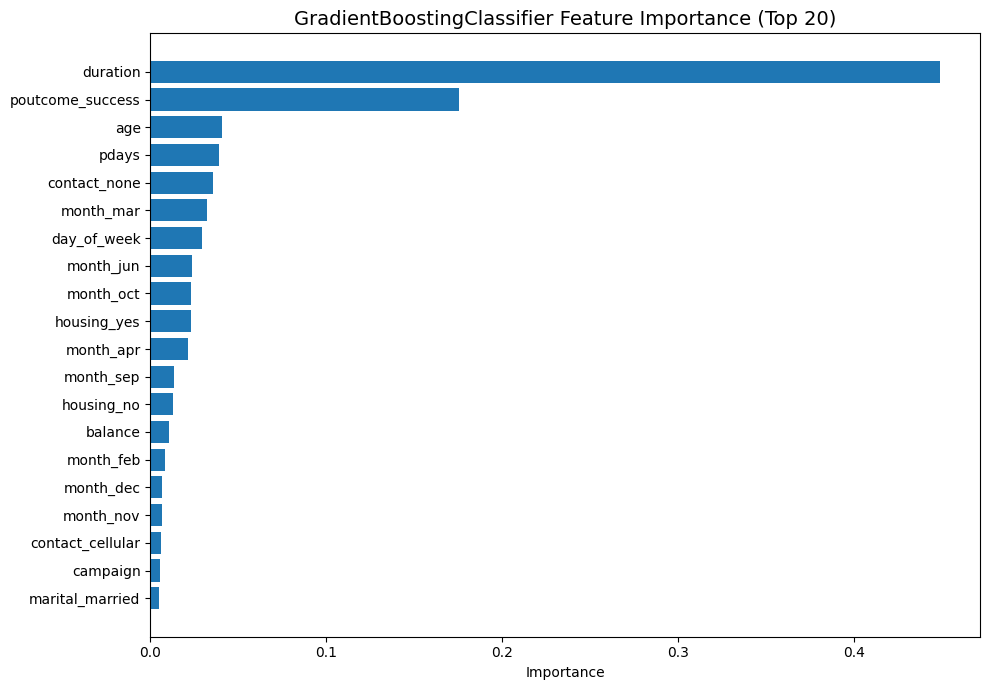

,feature,importance
3,duration,0.449186
50,poutcome_success,0.175235
0,age,0.040793
5,pdays,0.038856
33,contact_none,0.035867
42,month_mar,0.032017
2,day_of_week,0.029289
41,month_jun,0.023415
45,month_oct,0.023083
29,housing_yes,0.023065


In [21]:
# 1) Get the fitted preprocessor + model out of the pipeline
pre = gbc.named_steps["preprocess"]
model = gbc.named_steps["model"]

# 2) Build feature names after preprocessing (numeric + one-hot categorical)
num_features = pre.transformers_[0][2]  # numeric_cols
ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_features = pre.transformers_[1][2]  # categorical_cols
cat_feature_names = ohe.get_feature_names_out(cat_features)

feature_names = list(num_features) + list(cat_feature_names)

# 3) Pull feature importances
importances = model.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# 4) Plot top 20
top_n = 20
top = fi.head(top_n).sort_values("importance")  # sort for nicer horizontal bar plot

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(top["feature"], top["importance"])
ax.set_title(f"GradientBoostingClassifier Feature Importance (Top {top_n})", fontsize=14)
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

# optional: show the table too
fi.head(30)


### Conclusion

Overall, the GradientBoostingClassifier (gbc) outperformed the Logistic Regression baseline, with the most meaningful improvement appearing in recall for the positive class (customers who subscribed). While overall accuracy only increased modestly (about 90.7% for gbc vs. 90.1% for Logistic Regression), accuracy is not the most informative metric in this case because the dataset is highly imbalanced (approximately 88.3% “no” vs. 11.7% “yes”). In other words, even a naive model can appear strong by predicting the majority class most of the time. The real value of this project was not just improving the metrics, but understanding the structure and limitations of the data itself: both models highlighted different patterns of importance across the features, and together they reinforced a key insight—direct telemarketing campaigns tend to be successful when a potential client is actively engaged in a real phone conversation, regardless of demographic variation across the customer base. Whether a significantly stronger model could be built from this dataset alone remains an open question, but the results suggest that improvements may depend less on algorithm choice and more on collecting additional predictive features or reframing the prediction problem.